In [1]:
# This is a copy of my private kaggle kernel: https://www.kaggle.com/joatom/lgb-model
# fork of https://www.kaggle.com/inversion/atomic-distance-benchmark/

#J-Coupling:https://www.youtube.com/watch?v=vnkk3eli1Hc

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.model_selection import KFold,GroupKFold
import lightgbm as lgb

from matplotlib import pyplot as plt

import gc
import psutil
import os
import time
from functools import reduce

print(os.listdir("../input"))

['champs-scalar-coupling', 'main-features']


In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error as mmse
from sklearn.metrics import mean_absolute_error as mmae

# General Functions

In [3]:
in_path='../input/champs-scalar-coupling/'
mf_path='../input/main-features/'

In [4]:
#train=pd.read_pickle(mf_path+'train_ext_1JHN.zip',compression='zip')
#train.head()

In [5]:
# https://www.kaggle.com/todnewman/keras-neural-net-for-champs/comments
def show_ram_usage():
    py = psutil.Process(os.getpid())
    print('RAM usage: {} GB'.format(py.memory_info()[0]/2. ** 30))

In [6]:
# https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
# https://www.kaggle.com/c/champs-scalar-coupling/discussion/96655#latest-565815
# guiferviz comment

def reduce_memory_usage(df, deep=True, verbose=True, categories=True):
    # All types that we want to change for "lighter" ones.
    # int8 and float16 are not include because we cannot reduce
    # those data types.
    # float32 is not include because float16 has too low precision.
    numeric2reduce = ["int16", "int32", "int64", "float64"]
    start_mem = 0
    if verbose:
        start_mem = df.memory_usage().sum() / 1024**2

    for col, col_type in df.dtypes.iteritems():
        best_type = None
        if col_type == "object":
            df[col] = df[col].astype("category")
            best_type = "category"
        elif col_type in numeric2reduce:
            downcast = "integer" if "int" in str(col_type) else "float"
            df[col] = pd.to_numeric(df[col], downcast=downcast)
            best_type = df[col].dtype.name
        # Log the conversion performed.
        if verbose and best_type is not None and best_type != str(col_type):
            print(f"Column '{col}' converted from {col_type} to {best_type}")

    if verbose:
        end_mem = df.memory_usage().sum() / 1024**2
        diff_mem = start_mem - end_mem
        percent_mem = 100 * diff_mem / start_mem
        print(f"Memory usage decreased from"
              f" {start_mem:.2f}MB to {end_mem:.2f}MB"
              f" ({diff_mem:.2f}MB, {percent_mem:.2f}% reduction)")
    return df

# lgb

In [7]:

wctn_num=8
#path = Path('../input')

np.random.seed(2019)

fin_preds =[]
fin_preds_idx =[]
fin_train_idx=[]
ras_all=[]
raa_all=[]
nn_preds_valid_a =[]
y_valid_nn_a =[]

#procs = [FillMissing, Categorify, Normalize]
bs= 256

dep_var = 'scalar_coupling_constant'



In [8]:
show_ram_usage()

RAM usage: 0.13554763793945312 GB


In [9]:
#train.groupby('type')['x_0'].count()

In [10]:
#train[dep_var].hist(by=train['type'],figsize=(10,10))

In [11]:
#X[(X['scalar_coupling_constant']>190) & (X['type']=='1JHC')] #.groupby('type').count()
#train['type'].unique()

In [12]:
%%time

features=['atom_0','num_atoms_in_mol_x','nn1_0','nn1_dist_0','nn2_0','nn2_dist_0','nn3_0','nn3_dist_0','nn4_0','nn4_dist_0','nn5_0','nn5_dist_0','nn6_0',
          'nn6_dist_0','nn7_0','nn7_dist_0','nn8_0','nn8_dist_0','nn9_0','nn9_dist_0','atom_1','nn1_1','nn1_dist_1','nn2_1','nn2_dist_1','nn3_1','nn3_dist_1',
          'nn4_1','nn4_dist_1','nn5_1','nn5_dist_1','nn6_1','nn6_dist_1','nn7_1','nn7_dist_1','nn8_1','nn8_dist_1','nn9_1','nn9_dist_1','C','F','H','N','O',
          'mulliken_charge_0','mulliken_charge_1',
          #'common_nn_0',
          #'common_nn_1',
          'common_nn_dist_1',
          #'common_nn_2',
          'common_nn_dist_2',
          #'common_nn_3',
          'common_nn_dist_3',
          #'common_nn_4',
          'common_nn_dist_4',
          #'common_nn_5',
          'common_nn_dist_5',
          #'common_nn_6',
          'common_nn_dist_6',
          #'common_nn_7',
          'common_nn_dist_7',
          #'common_nn_8',
          'common_nn_dist_8',
          #'common_nn_9',
          'common_nn_dist_9',
          #'nn_1_0_exists','nn_1_1_exists','nn_2_0_exists','nn_2_1_exists','nn_3_0_exists','nn_3_1_exists','nn_4_0_exists','nn_4_1_exists',
          #'nn_5_0_exists','nn_5_1_exists','nn_6_0_exists','nn_6_1_exists','nn_7_0_exists','nn_7_1_exists','nn_8_0_exists','nn_8_1_exists','nn_9_0_exists',
          #'nn_9_1_exists',
          #'2J_nn','3J_nn',
          'dist','dist_cos','dist_mol_c_0','dist_mol_c_1','2J_angle','3J_angle','dist_nn_0_1','dist_nn_1_1','dist_nn_0_2',
          'dist_nn_1_2','dist_nn_0_3','dist_nn_1_3','dist_nn_0_4','dist_nn_1_4','dist_nn_0_5','dist_nn_1_5','dist_nn_0_6','dist_nn_1_6','dist_nn_0_7',
          'dist_nn_1_7','dist_nn_0_8','dist_nn_1_8','dist_nn_0_9','dist_nn_1_9','dihedral','bonds',
          #'yukawa_0','yukawa_1',
          #'coulomb_0','coulomb_1',
          'vander_0','vander_1']

types_to_run = ['3JHC', '2JHC', '1JHC', '2JHH', '1JHN', '2JHN', '3JHH', '3JHN'] #train['type'].unique() ## #['3JHC']:#['3JHC']:#

np.random.seed(2019)
for wctn in types_to_run:
    print('')
    print('###############',wctn,'###################')
    print('')
    train=pd.read_pickle(mf_path+'train_ext_'+wctn+'.zip',compression='zip')
    test=pd.read_pickle(mf_path+'test_ext_'+wctn+'.zip',compression='zip')
    
    #https://www.kaggle.com/titericz/giba-r-data-table-simple-features-1-17-lb
   # train['yukawa_0']= np.exp(-train['nn1_dist_0'])+np.exp(-train['nn2_dist_0'])+np.exp(-train['nn3_dist_0'])+np.exp(-train['nn4_dist_0'])#+np.exp(-train['nn5_dist_0'])
    #train['yukawa_1']= np.exp(-train['nn1_dist_1'])+np.exp(-train['nn2_dist_1'])+np.exp(-train['nn3_dist_1'])+np.exp(-train['nn4_dist_1'])#+np.exp(-train['nn5_dist_1'])
   # test['yukawa_0']= np.exp(-test['nn1_dist_0'])+np.exp(-test['nn2_dist_0'])+np.exp(-test['nn3_dist_0'])+np.exp(-test['nn4_dist_0'])#+np.exp(-test['nn5_dist_0'])
   # test['yukawa_1']= np.exp(-test['nn1_dist_1'])+np.exp(-test['nn2_dist_1'])+np.exp(-test['nn3_dist_1'])+np.exp(-test['nn4_dist_1'])#+np.exp(-test['nn5_dist_1'])
    
    #train['coulomb_0']= 1/(train['nn1_dist_0']+1e-8)+1/(train['nn2_dist_0']+1e-8)+1/(train['nn3_dist_0']+1e-8)+1/(train['nn4_dist_0']+1e-8)#+np.exp(-train['nn5_dist_0'])
    #train['coulomb_1']= 1/(train['nn1_dist_1']+1e-8)+1/(train['nn2_dist_1']+1e-8)+1/(train['nn3_dist_1']+1e-8)+1/(train['nn4_dist_1']+1e-8)#+np.exp(-train['nn5_dist_1'])
    #test['coulomb_0']= 1/(test['nn1_dist_0']+1e-8)+1/(test['nn2_dist_0']+1e-8)+1/(test['nn3_dist_0']+1e-8)+1/(test['nn4_dist_0']+1e-8)#+np.exp(-test['nn5_dist_0'])
    #test['coulomb_1']= 1/(test['nn1_dist_1']+1e-8)+1/(test['nn2_dist_1']+1e-8)+1/(test['nn3_dist_1']+1e-8)+1/(test['nn4_dist_1']+1e-8)#+np.exp(-test['nn5_dist_1'])
    
    train['vander_0']= 1/((train['nn1_dist_0']+1e-8)**3)+1/((train['nn2_dist_0']+1e-8)**3)+1/((train['nn3_dist_0']+1e-8)**3)+1/((train['nn4_dist_0']+1e-8)**3)#+np.exp(-train['nn5_dist_0'])
    train['vander_1']= 1/((train['nn1_dist_1']+1e-8)**3)+1/((train['nn2_dist_1']+1e-8)**3)+1/((train['nn3_dist_1']+1e-8)**3)+1/((train['nn4_dist_1']+1e-8)**3)#+np.exp(-train['nn5_dist_1'])
    test['vander_0']= 1/((test['nn1_dist_0']+1e-8)**3)+1/((test['nn2_dist_0']+1e-8)**3)+1/((test['nn3_dist_0']+1e-8)**3)+1/((test['nn4_dist_0']+1e-8)**3)#+np.exp(-test['nn5_dist_0'])
    test['vander_1']= 1/((test['nn1_dist_1']+1e-8)**3)+1/((test['nn2_dist_1']+1e-8)**3)+1/((test['nn3_dist_1']+1e-8)**3)+1/((test['nn4_dist_1']+1e-8)**3)#+np.exp(-test['nn5_dist_1'])
        
    
    train=reduce_memory_usage(train)
    test=reduce_memory_usage(test)
    
    gc.collect()
    show_ram_usage()
    
    cat_names = ['atom_1', 'atom_0','nn1_0','nn2_0','nn3_0','nn4_0','nn5_0','nn6_0','nn1_1','nn2_1','nn3_1','nn4_1','nn5_1','nn6_1']
    cont_names = list(set(train.columns)-set(cat_names+[dep_var,'type','id'])) 
    #print(cat_names, cont_names)
    
    print(wctn,'started...')
    id_train_wctn=train[train['type']==wctn]['id']
    y_train_wctn=train[train['type']==wctn][dep_var]
    X_train_wctn=train[train['type']==wctn].drop(['id','type',dep_var],axis=1)#.reset_index()
    X_train_wctn=X_train_wctn[features]
    #print(X_train_wctn.info(200))
    id_test_wctn=test[test['type']==wctn]['id']
    X_test_wctn=test[test['type']==wctn].drop(['id','type'],axis=1)
    X_test_wctn=X_test_wctn[features]


    #print(X_test_wctn.info(200))
    train = None
    test = None
    gc.collect()
    
    predsNN=[None]
    
    yoof = np.zeros(len(X_train_wctn))
    yhat = np.zeros(len(X_test_wctn))

    lr=0.4
    n_est=20000
    n_splits = 5
    
    if wctn in ['1JHN','2JHN','3JHN']:
        lr=0.1
        n_est=20000
        n_splits = 5
    elif wctn in ['2JHH','3JHH']:
        n_est=10000
        lr=0.25 #0.4
        n_splits = 3 #5
    elif wctn in ['1JHC','2JHC',]:
        lr=0.25
        n_est=10000
        n_splits=3 #5
    elif wctn in ['3JHC']:
        lr=0.25
        n_est=10000#22000
        n_splits=3
    
    gkf = KFold(n_splits=n_splits, shuffle=True, random_state=2019)

    fold = 0
    for in_index, oof_index in gkf.split(X_train_wctn, y_train_wctn):
        fold += 1
        print(f'fold {fold} of {n_splits}')
        X_in, X_oof = X_train_wctn.values[in_index], X_train_wctn.values[oof_index]
        y_in, y_oof = y_train_wctn.values[in_index], y_train_wctn.values[oof_index]
        
        #model = XGBRegressor(n_estimators=n_est, learning_rate=lr, random_state=2019, tree_method = 'gpu_exact')#0.1
        
        #model.fit(X_in, y_in, early_stopping_rounds=100, eval_set=[(X_oof, y_oof)], verbose=False, eval_metric = 'mae')

        #https://www.kaggle.com/artgor/using-meta-features-to-improve-model
        model=lgb.LGBMRegressor(max_depth= 9, learning_rate= lr, num_leaves= 128,  n_estimators= n_est, n_jobs= -1)
        model = model.fit(X_in, y_in, categorical_feature='auto',
                    eval_set=[(X_oof, y_oof)], eval_metric='mae',
                    verbose=200, early_stopping_rounds=20)

        
        print('## lr:',lr,'n_est:',n_est)
        #print('Best iteration: '+ str(model.best_iteration), 'Best ntree_limit: '+ str(model.best_ntree_limit), 'Best score:', str(model.best_score)) #model.best_score,
        
        yoof[oof_index] = model.predict(X_oof,num_iteration=model.best_iteration_)
        yhat += model.predict(X_test_wctn.values,num_iteration=model.best_iteration_)
        gc.collect()

    yhat /= n_splits
    
    raa=mmae(yoof, y_train_wctn)
    print(wctn,'mae',raa)
    raa_all.append(raa)
    
    # for analysis
    nn_preds_valid_a.append(yoof)
    y_valid_nn_a.append(y_train_wctn)
    fin_train_idx.append(np.array(id_train_wctn))

    gc.collect()
    
    print(wctn,raa,len(X_test_wctn))
    fin_preds.append(np.array(yhat))
    fin_preds_idx.append(np.array(id_test_wctn))
    
    y_train_wctn=None
    X_train_wctn=None
    id_test_wctn=None
    X_test_wctn=None
    learn = None
    gc.collect()
    show_ram_usage()


############### 3JHC ###################



/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

Column 'nn3_0' converted from int16 to int8
Column 'nn4_0' converted from int16 to int8
Column 'nn5_0' converted from int16 to int8
Column 'nn3_1' converted from int16 to int8
Column 'nn4_1' converted from int16 to int8
Column 'nn5_1' converted from int16 to int8
Column 'vander_0' converted from float64 to float32
Column 'vander_1' converted from float64 to float32
Memory usage decreased from 920.42MB to 900.26MB (20.17MB, 2.19% reduction)
Column 'nn4_0' converted from int16 to int8
Column 'nn4_1' converted from int16 to int8
Column 'vander_0' converted from float64 to float32
Column 'vander_1' converted from float64 to float32
Memory usage decreased from 490.18MB to 482.44MB (7.74MB, 1.58% reduction)
RAM usage: 1.7610359191894531 GB
3JHC started...
fold 1 of 3
Training until validation scores don't improve for 20 rounds.
[200]	valid_0's l1: 0.452444	valid_0's l2: 0.433067
[400]	valid_0's l1: 0.405024	valid_0's l2: 0.354021
[600]	valid_0's l1: 0.380152	valid_0's l2: 0.316812
[800]	vali

In [13]:
#fin_preds

In [14]:
#model.get_booster().feature_names=features
#model.feature_types = None
#fig, ax = plt.subplots(1,1,figsize=(10,20))
#plot_importance(model, max_num_features = 200, ax=ax)

#### print('mae:',mmae(yoof, y_train_wctn))

In [15]:
#analyse_diff = X_train_wctn.merge(np.abs(predsNN-y_valid_nn).sort_values(ascending=False).to_frame(), left_index=True, right_index=True, copy=False)

#analyse_diff.sort_values(by='scalar_coupling_constant_y').tail(n=10)

In [16]:
np.mean(raa_all),raa_all, 'minVal of Preds:' ,[np.min(i) for i in fin_preds]

(0.2763840278395152,
 [0.29597574838238,
  0.29360015532995204,
  0.7053130763297982,
  0.17806769233117,
  0.30499002072308085,
  0.15008228869642956,
  0.18333876708634048,
  0.09970447383697066],
 'minVal of Preds:',
 [-15.363948444814978,
  -31.263600955229418,
  68.42867591011832,
  -26.06798564217757,
  28.593971450356964,
  -2.5576837613542565,
  -1.9902096610185118,
  -1.7777969451831712])

In [17]:
#np.concatenate(fin_preds),np.concatenate(fin_preds_idx)

In [18]:

output = pd.DataFrame({'id': np.concatenate(fin_preds_idx),
                       'scalar_coupling_constant': np.concatenate(fin_preds)})
output.to_csv('submission_last.csv', index=False)



print('Done!')

Done!


In [19]:


output2 = pd.DataFrame({'id': np.concatenate(fin_train_idx),
                       'scalar_coupling_constant': np.concatenate(nn_preds_valid_a)})
output2.to_csv('train_valid.csv', index=False)



print('Done!')

Done!


(array([ 183741., 1906761.,   18625.,   14777.,  201422.,  126842.,
          45265.,    3254.,       0.,    4855.]),
 array([-31.26360096,  -7.26356136,  16.73647824,  40.73651784,
         64.73655743,  88.73659703, 112.73663663, 136.73667623,
        160.73671582, 184.73675542, 208.73679502]),
 <a list of 10 Patch objects>)

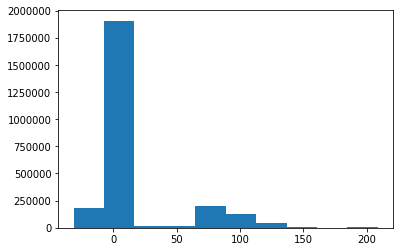

In [20]:

#train[dep_var].hist(), 
plt.hist(np.concatenate(fin_preds))

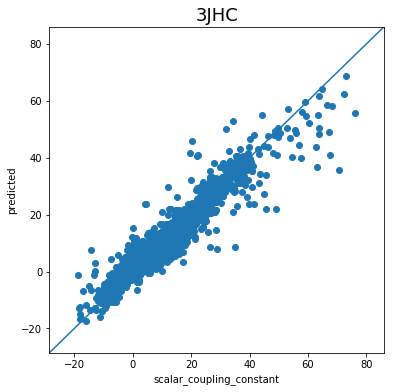

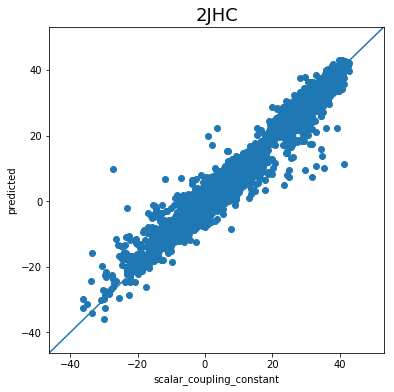

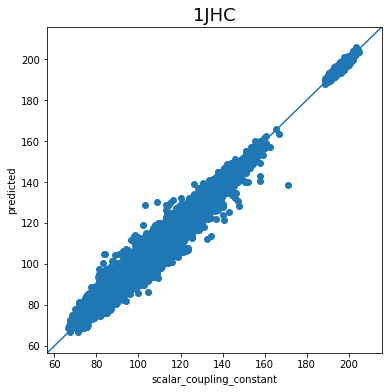

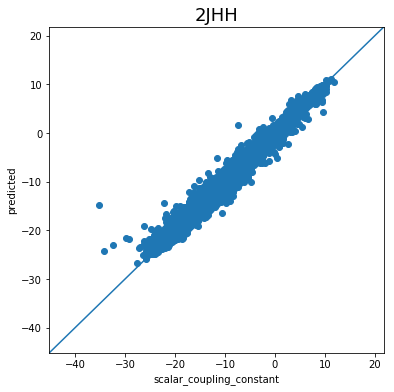

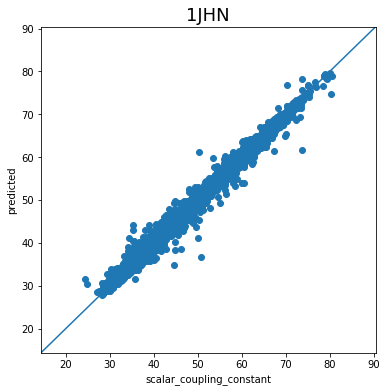

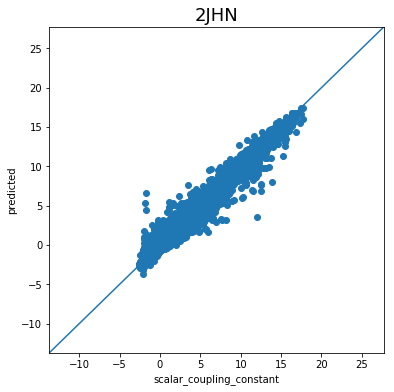

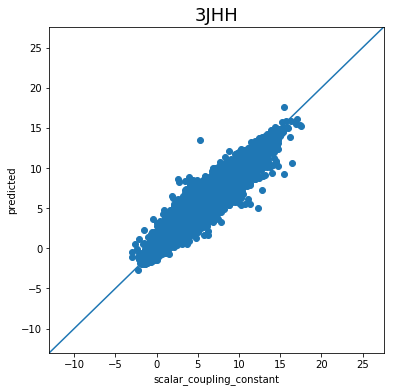

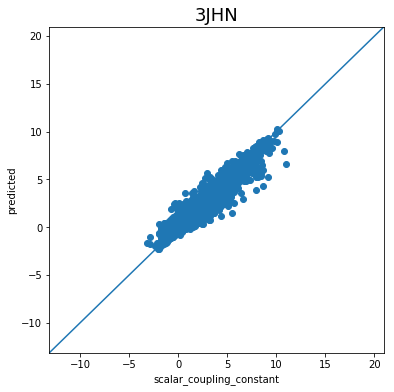

In [21]:
for i,t in enumerate(types_to_run):
    plt.figure(figsize=(6,6))
    plt.scatter(x=y_valid_nn_a[i], y=nn_preds_valid_a[i])
    
    llim =min(np.min(nn_preds_valid_a[i]),np.min(y_valid_nn_a[i]))-10
    ulim=max(np.max(nn_preds_valid_a[i]),np.max(y_valid_nn_a[i]))+10
    
    plt.xlabel('scalar_coupling_constant')
    plt.ylabel('predicted')
    plt.xlim((llim, ulim))
    plt.ylim((llim, ulim))
    plt.plot([llim, ulim], [llim, ulim])
    plt.title(t, fontsize=18)
    plt.show()

## Predictions

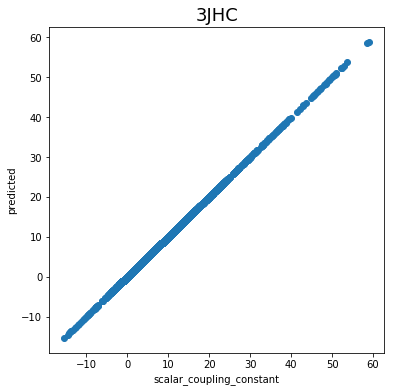

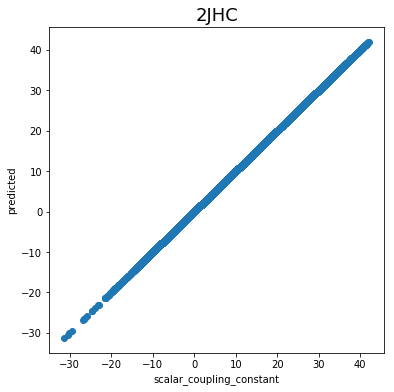

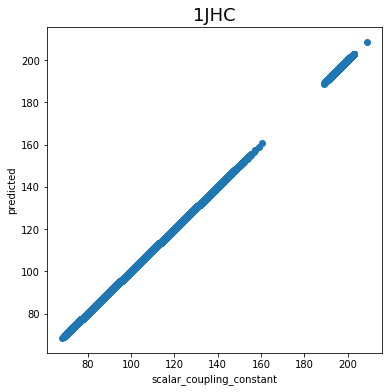

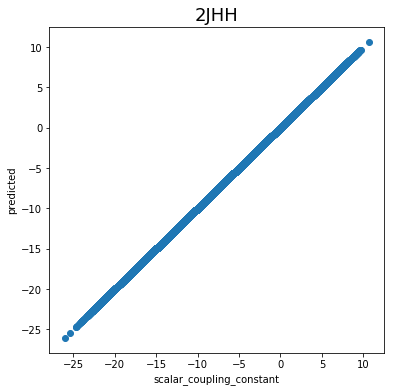

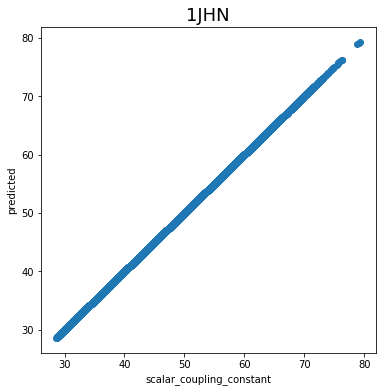

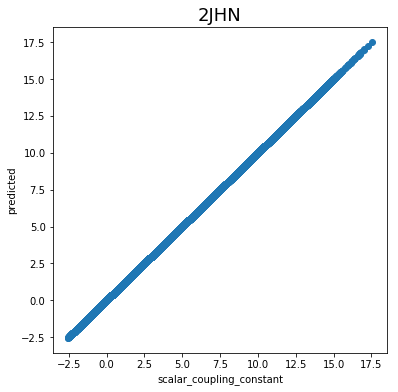

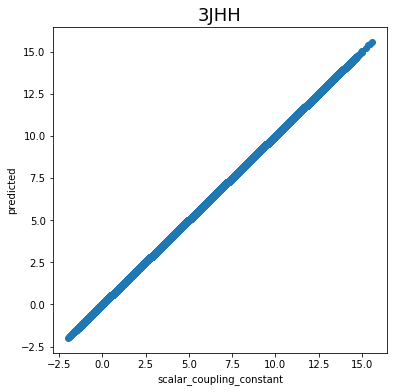

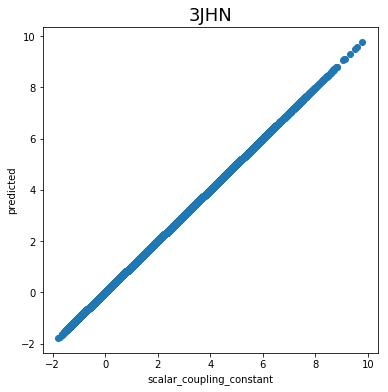

In [22]:
for i,t in enumerate(types_to_run):
    plt.figure(figsize=(6,6))
    
    plt.scatter(x=fin_preds[i], y=fin_preds[i])
    
    plt.xlabel('scalar_coupling_constant')
    plt.ylabel('predicted')
    plt.title(t, fontsize=18)
    plt.show()